<a href="https://colab.research.google.com/github/Jim-Yang98/churnpredict_exploration/blob/main/%E9%A0%90%E6%B8%AC%E6%B5%81%E5%A4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 載入常用函示庫

In [ ]:
try:
  from google.colab import drive, files
  in_colab = True
except ModuleNotFoundError:
  in_colab = False
if in_colab:
  home_dir = ''
  drive.mount('/content/drive')
  groot_dir = '/content/drive/My Drive/'
else:
  from patlib import path
  home_dir = str (Path.home())
  groot_dir = home_dir + '/Google Drive/'

import numpy as np
import pylab as pl
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

data_dir = groot_dir + 'predict/'
figure_dir = groot_dir + 'predict/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)
local_time = lambda x, offset: x + relativedelta(hours= offset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 作圖函式
def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    # plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

def grid_plot(figsize=(18, 14), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    # plt.tight_layout()
    gs=fig.add_gridspec(2, 2)
    with sns.axes_style(style):
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
    return [ax0, ax1, ax2, ax3]

# 資料特徵盤點

In [ ]:
csv_path = os.path.join(data_dir, 'Baza_customer_Telecom_v2.csv')
df = pd.read_csv(csv_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8453 entries, 0 to 8452
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PID                     8453 non-null   object 
 1   CRM_PID_Value_Segment   8448 non-null   object 
 2   EffectiveSegment        8453 non-null   object 
 3   Billing_ZIP             8451 non-null   float64
 4   KA_name                 8453 non-null   object 
 5   Active_subscribers      8453 non-null   int64  
 6   Not_Active_subscribers  4304 non-null   float64
 7   Suspended_subscribers   352 non-null    float64
 8   Total_SUBs              8453 non-null   int64  
 9   AvgMobileRevenue        8453 non-null   float64
 10  AvgFIXRevenue           8453 non-null   float64
 11  TotalRevenue            8453 non-null   float64
 12  ARPU                    8452 non-null   float64
 13  CHURN                   8453 non-null   object 
dtypes: float64(7), int64(2), object(5)
memor

In [ ]:
df.isnull().sum()

,0
PID,0
CRM_PID_Value_Segment,5
EffectiveSegment,0
Billing_ZIP,2
KA_name,0
Active_subscribers,0
Not_Active_subscribers,4149
Suspended_subscribers,8101
Total_SUBs,0
AvgMobileRevenue,0


<Axes: >

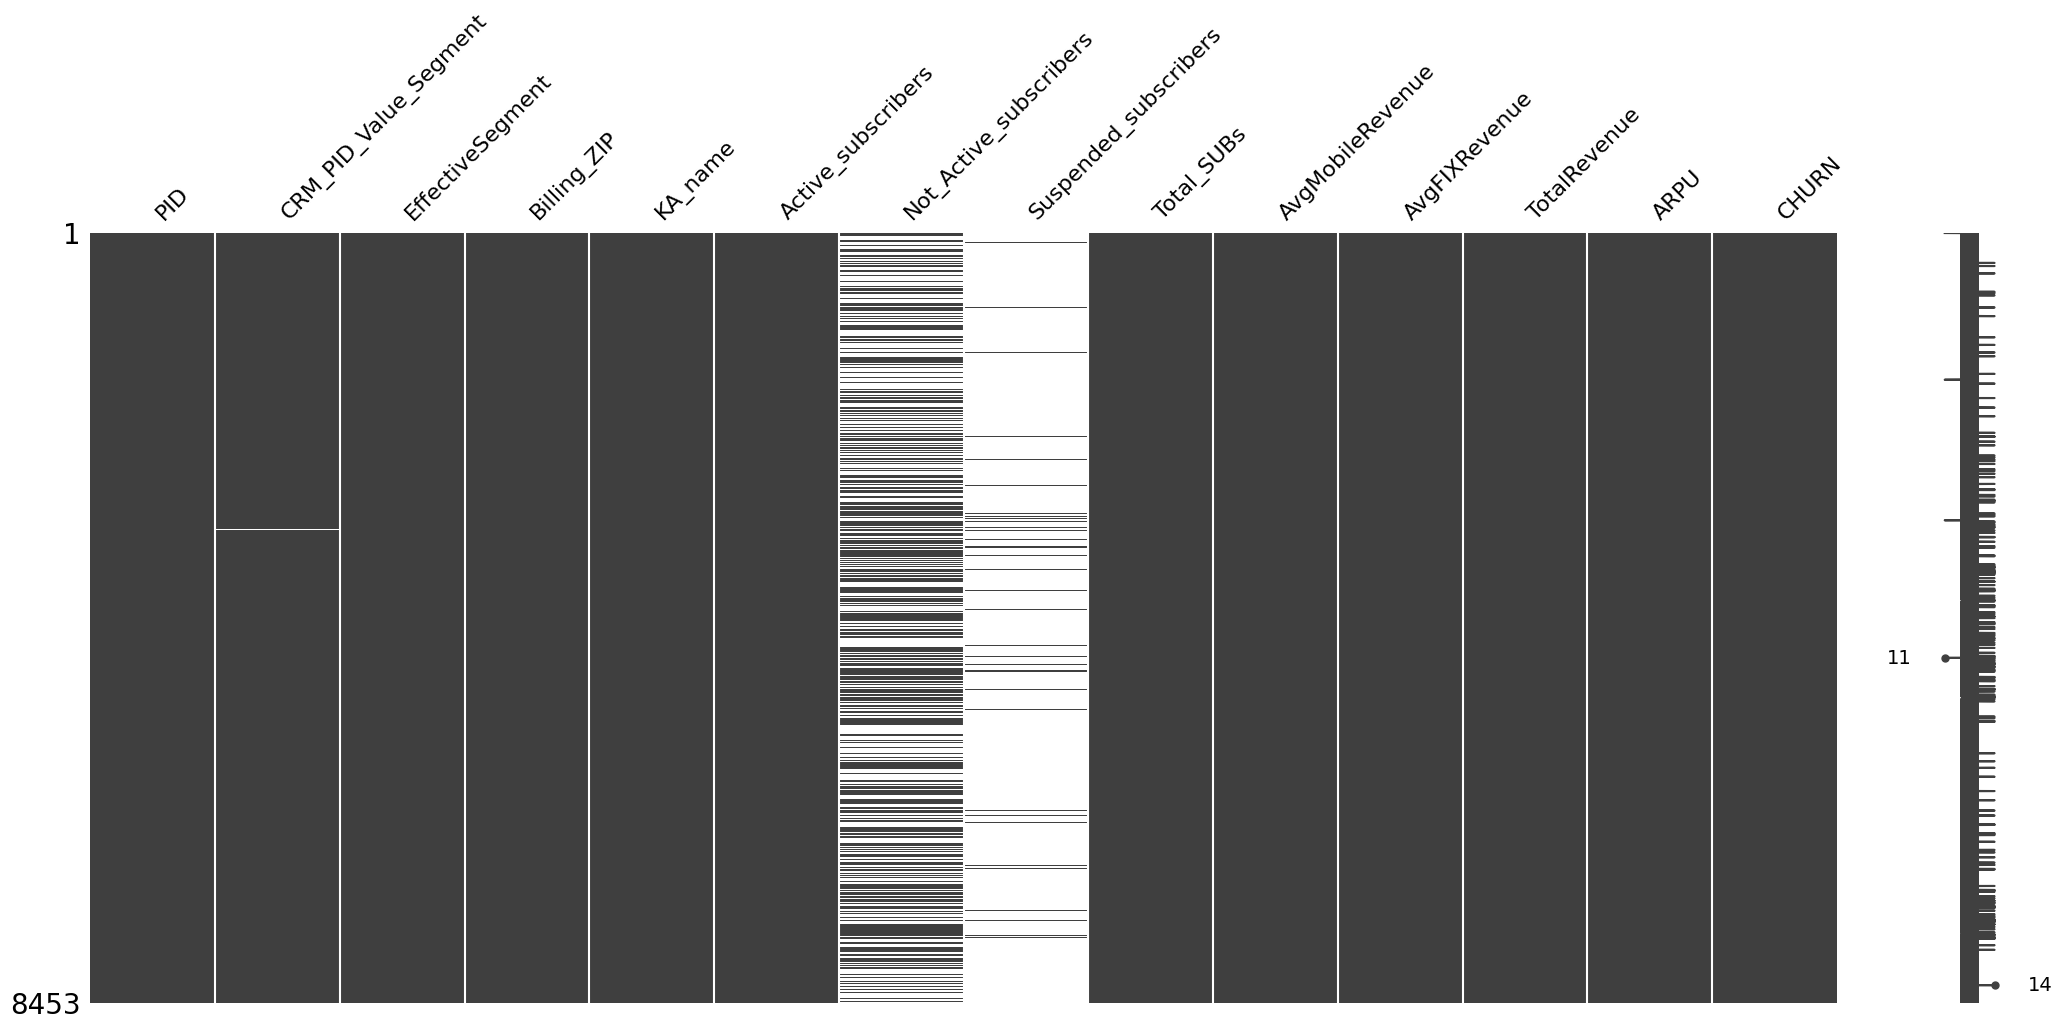

In [ ]:
# 資料缺失值作圖
import missingno as msno
%matplotlib inline
msno.matrix(df)

缺失值 <5 好像不會顯示

In [ ]:
def count_not_num_col(df):
  """
  確認所有object的內容
  """
  n_n_cols = df.select_dtypes(include=['object']).columns
  print(f"共有 {len(n_n_cols)} 個類別欄位\n")

  for col in n_n_cols:
    print(f"欄位名稱：{col}")
    print(df[col].value_counts(dropna=False))
    print("--"*10)

In [ ]:
count_not_num_col(df)

共有 5 個類別欄位

欄位名稱：PID
PID
2.02E+12     5
1.29E+12     5
1.22E+12     4
1.21E+12     4
8.32E+12     3
            ..
160094020    1
160138754    1
115540715    1
200431344    1
115138499    1
Name: count, Length: 8436, dtype: int64
--------------------
欄位名稱：CRM_PID_Value_Segment
CRM_PID_Value_Segment
Bronze      3820
Silver      2039
Gold        1453
Platinum     537
SME          284
Iron         246
SE            41
Lead          27
NaN            5
Sliver         1
Name: count, dtype: int64
--------------------
欄位名稱：EffectiveSegment
EffectiveSegment
SOHO     6301
VSE      1795
SME       284
SE         42
Other      29
LE          2
Name: count, dtype: int64
--------------------
欄位名稱：KA_name
KA_name
VM                   769
RJ                   751
Tatiana Trifonova    719
Ginka Vachkova       715
Jenia Gogova         714
MT                   710
AD?                  707
VU                   696
DI                   695
AD                   694
VT                   681
Daniela Stefanova

欄位說明
1. CRM_PID_Value_Segment
* Iron Bronze Silver Gold Platinum：可能為客戶價值排序
* Lead：可能指未轉化的客戶
* NaN：未紀錄
* Sliver:極可能是打錯，應該歸類為silver
2. EffectiveSegment
* SOHO：Small Office / Home Office
* VSE：Very Small Enterprise
* SME：Small & Medium Enterprise
* SE：Self-Employed
* LE：Large Enterprise
3. KA_name是The name of their Key Account Manager who serves them
* AD?：替代成UNKNOW


紀錄:
1. ARPU 用戶平均收入
2. PID可不理
3. crm 裡的SME、SE可能可以刪除

# 資料清理與特徵工程

## 缺失值處理

In [ ]:
mask = (
    (df["CRM_PID_Value_Segment"] == "SME") |
    (df["EffectiveSegment"] == "SME")
)

df_sme = df[mask]

In [ ]:
df_sme.iloc[101:150, :]

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
7387,112607062,Unclassified,SME,4000.0,MT,22,13.0,0.0,35,361.83,0.0,361.83,16.45,No
7394,115158929,Unclassified,SME,4023.0,MT,2,15.0,0.0,17,162.17,0.0,162.17,81.09,No
7395,115176400,Unclassified,SME,4004.0,MT,27,8.0,3.0,38,433.17,55.0,488.17,16.04,Yes
7396,115246681,Unclassified,SME,4000.0,MT,31,0.0,0.0,31,482.67,0.0,482.67,15.57,Yes
7398,115511215,Unclassified,SME,4004.0,MT,31,6.0,0.0,37,488.33,0.0,488.33,15.75,No
7403,115603585,Unclassified,SME,4004.0,MT,18,16.0,0.0,34,321.50,0.0,321.50,17.86,No
7405,115639275,Unclassified,SME,4003.0,MT,9,0.0,0.0,9,325.83,0.0,325.83,36.20,No
7409,115827416,Unclassified,SME,4004.0,MT,18,18.0,1.0,37,421.67,0.0,421.67,23.43,No
7410,115879797,Iron,SME,4300.0,MT,18,0.0,0.0,18,162.33,0.0,162.33,9.02,No
7411,115896743,Unclassified,SME,4000.0,MT,9,2.0,0.0,11,368.50,35.0,403.50,40.94,No


可能將CRM裡面的SME改成Unclassified

初步想法是未分類的人之後透過觀察CRM的分層方式用手動方式幫他們補上適合的級別。

In [ ]:
mask2 = (
    (df["CRM_PID_Value_Segment"] == "SE") |
    (df["EffectiveSegment"] == "SE")
)

# df_se = df[mask2]

In [ ]:
df[mask2]

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
7390,115011562,SE,SE,4340.0,MT,25,9.0,NaN,34,331.00,0.00,331.00,13.24,No
7445,8.32E+12,SE,SE,4023.0,MT,30,NaN,NaN,30,406.50,1.83,408.33,13.55,No
7446,802299,SE,SE,6280.0,DI,4,NaN,NaN,4,285.33,0.00,285.33,71.33,No
7447,803060,SE,SE,6290.0,DI,2,NaN,NaN,2,48.00,0.00,48.00,24.00,No
7448,804058,SE,SE,6000.0,DI,26,3.0,NaN,29,347.17,6.00,353.17,13.35,No
7449,808028,SE,SE,6280.0,DI,4,NaN,NaN,4,85.00,0.00,85.00,21.25,No
7452,123636371,SE,SE,6000.0,DI,4,2.0,NaN,6,51.67,0.00,51.67,12.92,No
7453,123638707,SE,SE,6000.0,DI,7,NaN,NaN,7,71.83,0.00,71.83,10.26,No
7454,123710035,SE,SE,6000.0,DI,3,1.0,NaN,4,43.83,0.00,43.83,14.61,No
7455,123765220,SE,SE,6000.0,DI,3,NaN,NaN,3,70.67,0.00,70.67,23.56,No


In [ ]:
df.loc[
    (df["CRM_PID_Value_Segment"] == "SE") |
    (df["CRM_PID_Value_Segment"] == "SME"),
    "CRM_PID_Value_Segment"
] = "Unclassified"

In [ ]:
df.loc[(df["CRM_PID_Value_Segment"] == "Sliver"), "CRM_PID_Value_Segment"] = "Silver"

In [ ]:
df["CRM_PID_Value_Segment"].value_counts()

,count
CRM_PID_Value_Segment,
Bronze,3820
Silver,2040
Gold,1453
Platinum,537
Unclassified,325
Iron,246
Lead,27


In [ ]:
# Billing_ZIP 缺失值處理
df["Billing_ZIP"].value_counts()

,count
Billing_ZIP,
4000.0,1606
6000.0,1142
4400.0,467
4003.0,400
6300.0,338
...,...
6465.0,1
4583.0,1
4368.0,1


帳單郵遞區號的缺失值可能補眾數

In [ ]:
mode_value = df['Billing_ZIP'].mode()
mode_value

,Billing_ZIP
0,4000.0


In [ ]:
mode_value = df['Billing_ZIP'].mode()[0]
df["Billing_ZIP"] = df['Billing_ZIP'].fillna(mode_value)

In [ ]:
df['Billing_ZIP'].isnull().sum()

np.int64(0)

In [ ]:
# 處理大企業名字
df["KA_name"].value_counts()

,count
KA_name,
VM,769
RJ,751
Tatiana Trifonova,719
Ginka Vachkova,715
Jenia Gogova,714
MT,710
AD?,707
VU,696
DI,695


In [ ]:
df.loc[(df["KA_name"] == "Tatiana Trifonova"), "KA_name"] = "TT"

In [ ]:
df.loc[(df["KA_name"] == "Ginka Vachkova"), "KA_name"] = "GV"

In [ ]:
df.loc[(df["KA_name"] == "Jenia Gogova"), "KA_name"] = "JG"

In [ ]:
df.loc[(df["KA_name"] == "AD?"), "KA_name"] = "UNKNOW"

In [ ]:
df.loc[(df["KA_name"] == "Daniela Stefanova"), "KA_name"] = "DS"

In [ ]:
df["KA_name"].value_counts()

,count
KA_name,
VM,769
RJ,751
TT,719
GV,715
JG,714
MT,710
UNKNOW,707
VU,696
DI,695


In [ ]:
df["Not_Active_subscribers"].value_counts()

,count
Not_Active_subscribers,
1.0,1671
2.0,871
3.0,497
4.0,331
5.0,210
6.0,150
7.0,103
8.0,71
9.0,59


有訂閱+沒訂閱+暫停訂閱=總訂閱數
確認是否有訂閱數不符的row

In [ ]:
df["Not_Active_subscribers"].fillna(0, inplace=True)
df["Suspended_subscribers"].fillna(0, inplace=True)

/tmp/ipython-input-542804476.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Not_Active_subscribers"].fillna(0, inplace=True)
/tmp/ipython-input-542804476.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
mask = (
    df['Active_subscribers']
    + df['Not_Active_subscribers']
    + df['Suspended_subscribers']
) != df['Total_SUBs']

In [ ]:
mask.sum()

np.int64(0)

In [ ]:
# 法二
# e = 0
# for i in range(len(df)):
#     a = df.loc[i, 'Active_subscribers']
#     b = df.loc[i, 'Not_Active_subscribers']
#     c = df.loc[i, 'Suspended_subscribers']
#     d = df.loc[i, 'Total_SUBs']

#     if a + b + c != d:
#       e += 1
#       print(f"第 {i} 列不符：{a + b + c} != {d}")

# print("總共有", e, "列訂閱數不符")


總共有 0 列訂閱數不符


In [ ]:
# ARPU 缺失值處理
df.loc[df['ARPU'].isna()]

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
0,123759242,Bronze,SOHO,6000.0,VM,2,0.0,0.0,2,40.17,0.0,40.17,NaN,No


可能將缺失值補上其他總訂閱數為2的ARPU中位數

In [ ]:
# 確認 arpu==2 不只有一列
mask3 = (df['Total_SUBs'] == 2)

df[mask3]

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
0,123759242,Bronze,SOHO,6000.0,VM,2,0.0,0.0,2,40.17,0.0,40.17,NaN,No
12,123756730,Iron,SOHO,6000.0,DI,2,0.0,0.0,2,40.50,0.0,40.50,20.25,No
18,112594661,Bronze,SOHO,4500.0,AD,2,0.0,0.0,2,40.83,0.0,40.83,20.42,No
37,112111244,Iron,SOHO,4400.0,MT,2,0.0,0.0,2,41.33,0.0,41.33,20.67,No
42,112531322,Bronze,SOHO,4468.0,MT,2,0.0,0.0,2,41.67,0.0,41.67,20.84,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8428,160129310,Iron,SOHO,4027.0,DS,1,1.0,0.0,2,56.00,0.0,56.00,56.00,No
8434,160130636,Bronze,SOHO,4000.0,VT,2,0.0,0.0,2,56.00,0.0,56.00,28.00,No
8443,120552982,Bronze,SOHO,4700.0,VU,2,0.0,0.0,2,56.33,0.0,56.33,28.17,No
8446,200773974,Bronze,SOHO,4230.0,VU,2,0.0,0.0,2,56.33,0.0,56.33,28.17,No


In [ ]:
mask_valid = (df['Total_SUBs'] == 2) & (df['ARPU'].notna())

median_arpu2 = df.loc[mask_valid, "ARPU"].median()

mask_fill = (df['Total_SUBs'] == 2) & (df['ARPU'].isna())

df.loc[mask_fill, "ARPU"] = median_arpu2

In [ ]:
df['ARPU'].isnull().sum()

np.int64(0)

In [ ]:
df.iloc[8445:8449, :]

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
8445,115780653,Bronze,SOHO,4004.0,VU,4,3.0,0.0,7,56.33,0.0,56.33,14.08,No
8446,200773974,Bronze,SOHO,4230.0,VU,2,0.0,0.0,2,56.33,0.0,56.33,28.17,No
8447,200851056,Bronze,SOHO,4004.0,VU,2,0.0,0.0,2,56.33,0.0,56.33,28.17,No
8448,115901902,Iron,SOHO,4000.0,VU,2,1.0,0.0,3,56.50,0.0,56.50,28.25,No


In [ ]:
# CRM_PID_Value_Segment	缺失值處理
# 待處理
mask4 = (df['CRM_PID_Value_Segment'].isna())
df[mask4]

,PID,CRM_PID_Value_Segment,EffectiveSegment,Billing_ZIP,KA_name,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,AvgMobileRevenue,AvgFIXRevenue,TotalRevenue,ARPU,CHURN
2795,121348769,NaN,Other,1000.0,VT,8,1.0,0.0,9,144.00,0.0,144.00,18.00,No
3217,123676654,NaN,Other,6000.0,DI,7,3.0,0.0,10,168.17,0.0,168.17,24.02,No
3254,108026375,NaN,Other,6600.0,RJ,15,1.0,0.0,16,170.00,0.0,170.00,11.33,No
4663,108684448,NaN,Other,6600.0,RJ,12,0.0,0.0,12,316.25,0.0,316.25,26.35,No
5303,112038846,NaN,Other,4640.0,MT,8,1.0,0.0,9,126.50,0.0,126.50,15.81,No


紀錄：CRM的缺失值可能保留會比較好，維持資料原始性。

如果用ARPU推論，新增一欄作為標記會比較好，避免我破壞資料原始性。

In [ ]:
# 假如真要靠推論補植的話
# valid_segments = ["Iron", "Bronze", "Silver", "Gold", "Platinum"]

# ref = (
#     df[
#         df["CRM_PID_Value_Segment"].isin(valid_segments) &
#         df["ARPU"].notna()
#     ]
#     .groupby("CRM_PID_Value_Segment")["ARPU"]
#     .median()
#     .sort_values()
# )

# def infer_segment(arpu, thresholds):
#     if pd.isna(arpu):
#         return None
#     if arpu < thresholds["Bronze"]:
#         return "Iron"
#     elif arpu < thresholds["Silver"]:
#         return "Bronze"
#     elif arpu < thresholds["Gold"]:
#         return "Silver"
#     elif arpu < thresholds["Platinum"]:
#         return "Gold"
#     else:
#         return "Platinum"

In [ ]:
df["CRM_PID_Value_Segment"] = (
    df["CRM_PID_Value_Segment"]
    .fillna("Unclassified")
)

In [ ]:
df.isnull().sum()

,0
PID,0
CRM_PID_Value_Segment,0
EffectiveSegment,0
Billing_ZIP,0
KA_name,0
Active_subscribers,0
Not_Active_subscribers,0
Suspended_subscribers,0
Total_SUBs,0
AvgMobileRevenue,0


In [ ]:
df['CRM_PID_Value_Segment'].value_counts()

,count
CRM_PID_Value_Segment,
Bronze,3820
Silver,2039
Gold,1453
Platinum,537
Unclassified,331
Iron,246
Lead,27


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8453 entries, 0 to 8452
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PID                     8453 non-null   object 
 1   CRM_PID_Value_Segment   8453 non-null   object 
 2   EffectiveSegment        8453 non-null   object 
 3   Billing_ZIP             8453 non-null   float64
 4   KA_name                 8453 non-null   object 
 5   Active_subscribers      8453 non-null   int64  
 6   Not_Active_subscribers  8453 non-null   float64
 7   Suspended_subscribers   8453 non-null   float64
 8   Total_SUBs              8453 non-null   int64  
 9   AvgMobileRevenue        8453 non-null   float64
 10  AvgFIXRevenue           8453 non-null   float64
 11  TotalRevenue            8453 non-null   float64
 12  ARPU                    8453 non-null   float64
 13  CHURN                   8453 non-null   object 
dtypes: float64(7), int64(2), object(5)
memor

<Axes: xlabel='CHURN', ylabel='count'>

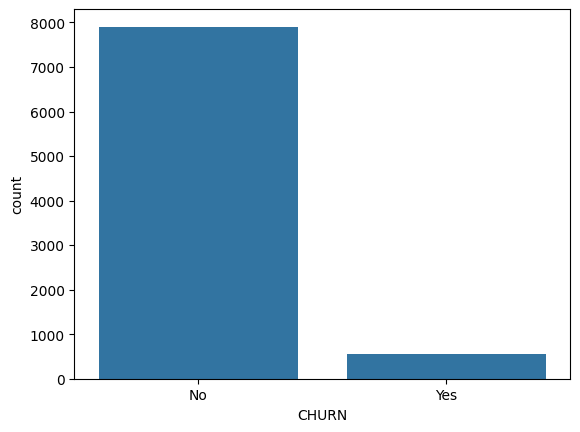

In [ ]:
# 流失率
sns.countplot(x='CHURN', data=df)

標準的常見分布:流失為少部分人

In [ ]:
# calculate the churn rate for each billing_zip
# df.loc[df['CHURN'] == 1, 'Billing_ZIP'].unique()

array([], dtype=float64)

In [ ]:
# 感覺是重要特徵
df.loc[df['CHURN'] == 1, 'Billing_ZIP'].value_counts()

,count
Billing_ZIP,
4000.0,113
6000.0,58
4400.0,29
4230.0,24
4004.0,23
...,...
4224.0,1
4638.0,1
4630.0,1


<Axes: xlabel='count', ylabel='CRM_PID_Value_Segment'>

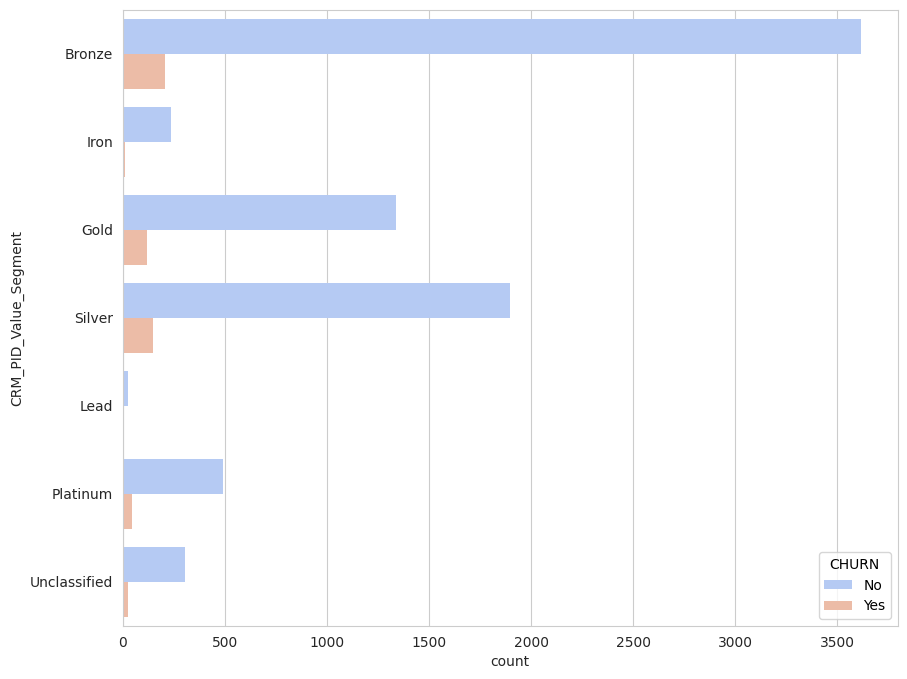

In [ ]:
ax = start_plot()
sns.countplot(y='CRM_PID_Value_Segment', hue='CHURN',
              palette='coolwarm', data=df)

大多用戶評級落在銅銀位置

<Axes: xlabel='count', ylabel='EffectiveSegment'>

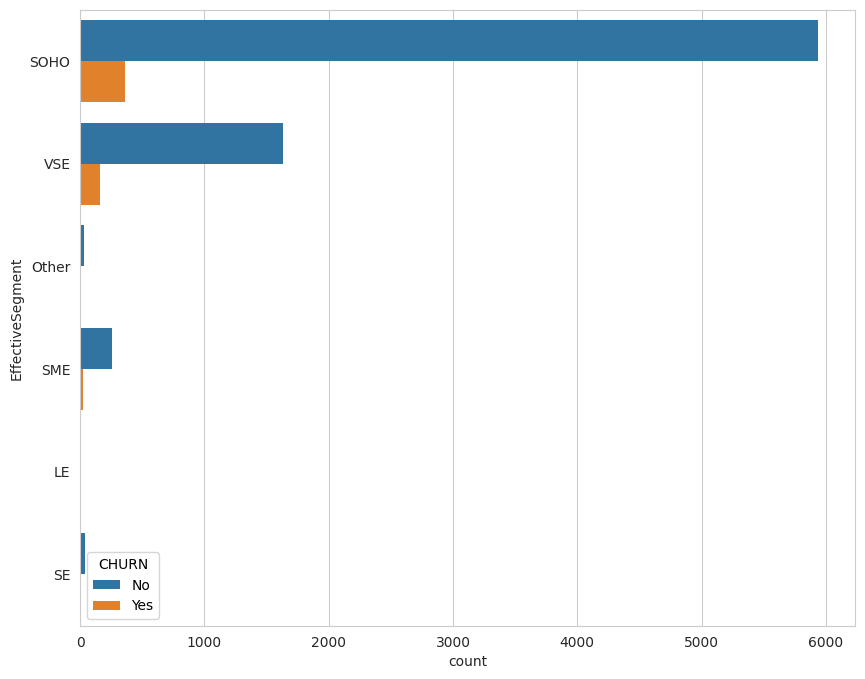

In [ ]:
ax = start_plot()
sns.countplot(y='EffectiveSegment', hue='CHURN',
               data=df)

小工作室(SOHO)是占最多用戶，流失也是最高

In [ ]:
df.loc[df['EffectiveSegment'] == 'LE', 'EffectiveSegment']

,EffectiveSegment
4499,LE
7208,LE


<Axes: xlabel='KA_name', ylabel='count'>

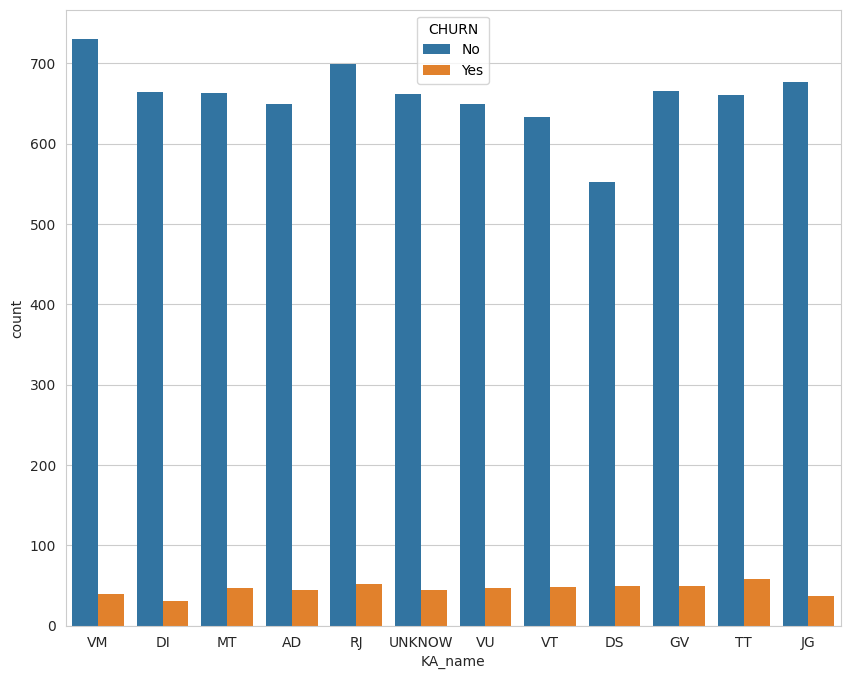

In [ ]:
ax = start_plot()
sns.countplot(x='KA_name', hue='CHURN',
               data=df)

每位業務所流失的用戶數差不多

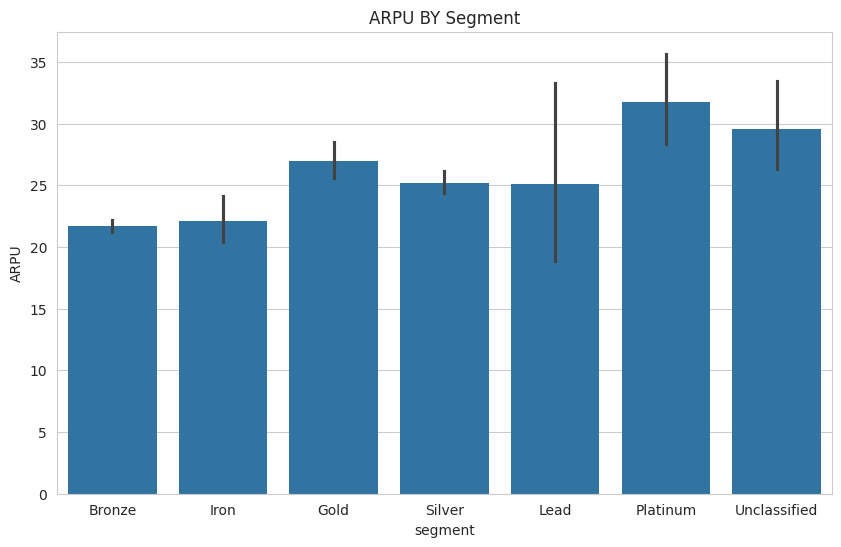

In [ ]:
ax = start_plot(figsize=(10, 6))

sns.barplot(
    data=df,
    x="CRM_PID_Value_Segment",
    y="ARPU",
    ax=ax
)

ax.set_title("ARPU BY Segment")
ax.set_xlabel("segment")
ax.set_ylabel("ARPU")

plt.show()

用戶平均收入的高低大致和用戶評級成正比

In [ ]:
# ready_df =df.copy()
# ready_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8453 entries, 0 to 8452
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PID                     8453 non-null   object 
 1   CRM_PID_Value_Segment   8453 non-null   object 
 2   EffectiveSegment        8453 non-null   object 
 3   Billing_ZIP             8453 non-null   float64
 4   KA_name                 8453 non-null   object 
 5   Active_subscribers      8453 non-null   int64  
 6   Not_Active_subscribers  8453 non-null   float64
 7   Suspended_subscribers   8453 non-null   float64
 8   Total_SUBs              8453 non-null   int64  
 9   AvgMobileRevenue        8453 non-null   float64
 10  AvgFIXRevenue           8453 non-null   float64
 11  TotalRevenue            8453 non-null   float64
 12  ARPU                    8453 non-null   float64
 13  CHURN                   0 non-null      float64
 14  mobile_ratio            8453 non-null   

## 特徵工程

衍生特徵

1.  mobile_ratio 高的客戶：手機為主
2.  fix_ratio 高的客戶:可能是家裡網路
*   這兩個不能一起進線性模型，樹模型可以
3.  df["active_ratio"]
4.  df["suspended_ratio"]:0的比例太高，在線性模型裡要改成二元
5.  df["KA_client"]:取代ka_name



類別編碼

*  CRM_PID_Value_Segment和EffectiveSegment:用one hot
*  KA_name:轉衍生特徵
*  CHURN:用map再drop

之後先作樹模型 再處理線性模型
* baseline 隨機樹
* 比較 LIGHTGBM

In [ ]:
df['AvgMobileRevenue'].value_counts()

,count
AvgMobileRevenue,
94.67,20
49.33,20
51.00,20
51.33,18
73.33,18
...,...
326.17,1
266.17,1
327.33,1


In [ ]:
# df[['AvgFIXRevenue', 'AvgMobileRevenue']].apply(pd.Series.value_counts)

,AvgFIXRevenue,AvgMobileRevenue
0.00,8331.0,1.0
0.17,1.0,NaN
0.33,1.0,NaN
0.83,1.0,NaN
1.50,1.0,NaN
...,...,...
498.00,NaN,1.0
498.67,NaN,1.0
498.83,NaN,2.0
499.17,NaN,1.0


In [ ]:
# 把家用和行動裝置比例算出
df["mobile_ratio"] = df["AvgMobileRevenue"] / (
    df["AvgMobileRevenue"] + df["AvgFIXRevenue"]
)

df["fix_ratio"] = 1 - df["mobile_ratio"]

In [ ]:
# 算出活躍度和停用率
# df["active_ratio"] = df["Active_subscribers"] / df["Total_SUBs"]
# df["suspended_ratio"] = df["Suspended_subscribers"] / df["Total_SUBs"]

In [ ]:
# 驗證是否需要 df['Suspended_subscribers'] 欄位
# 找出 df['Suspended_subscribers'] == 0 的欄位
mask_0 = df['Suspended_subscribers'] == 0
# 為0的欄位/總數
total_sus = len(df[mask_0])/len(df['Suspended_subscribers'])
# 印出
print(f"為0的比例為：{total_sus}")

為0的比例為：0.9583579794155921


In [ ]:
# 額外
# 低活躍度比例
# df["inactive_ratio"] = df["Not_Active_subscribers"] / df["Total_SUBs"]

In [ ]:
ka_pid = (
    df.groupby("KA_name")["PID"]
      .nunique()
      .reset_index(name="PID_count")
)

<Axes: xlabel='KA_name', ylabel='PID_count'>

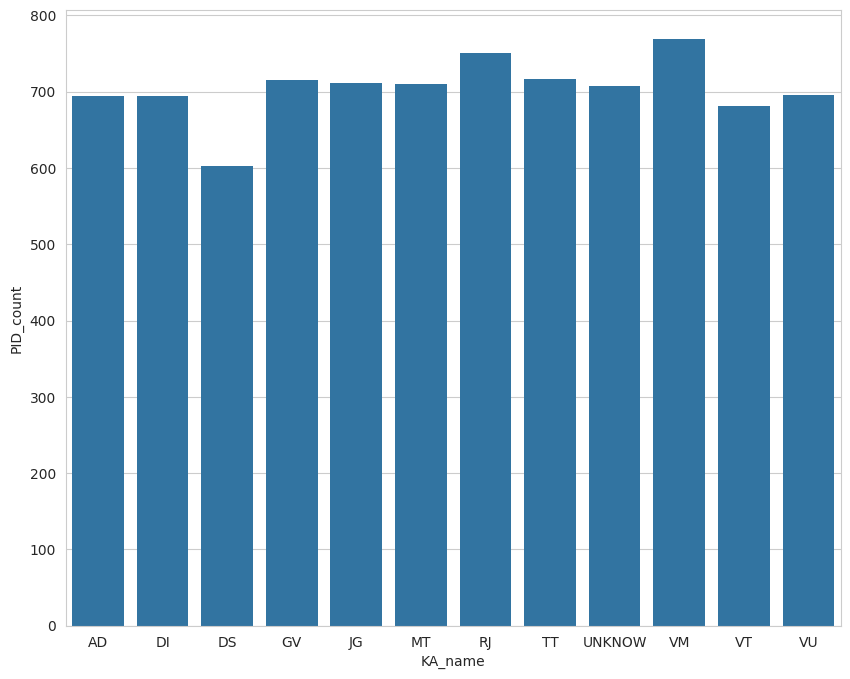

In [ ]:
# 驗證是否需要 df["KA_client"]
# 業務比例
ax = start_plot()
sns.barplot(y='PID_count', x='KA_name',
             data=ka_pid)

In [ ]:
# df["KA_client"] = df.groupby("KA_name")["PID"].transform("count")

這邊要先 drop，等切完資料要加再加，避免leakage

* 補充 KA_client高：業務負載重可能代表客戶被關照不足,問題回應慢,churn 風險上升

In [ ]:
df["CHURN"] = df["CHURN"].map({"No": 0, "Yes": 1})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8453 entries, 0 to 8452
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PID                     8453 non-null   object 
 1   CRM_PID_Value_Segment   8453 non-null   object 
 2   EffectiveSegment        8453 non-null   object 
 3   Billing_ZIP             8453 non-null   float64
 4   KA_name                 8453 non-null   object 
 5   Active_subscribers      8453 non-null   int64  
 6   Not_Active_subscribers  8453 non-null   float64
 7   Suspended_subscribers   8453 non-null   float64
 8   Total_SUBs              8453 non-null   int64  
 9   AvgMobileRevenue        8453 non-null   float64
 10  AvgFIXRevenue           8453 non-null   float64
 11  TotalRevenue            8453 non-null   float64
 12  ARPU                    8453 non-null   float64
 13  CHURN                   8453 non-null   int64  
 14  mobile_ratio            8453 non-null   

In [ ]:
# save as a csv
# df.to_csv(data_dir + 'prepare_drop.csv', index=False)

## 快速載入

In [ ]:
csv_path = os.path.join(data_dir, 'prepare_drop.csv')
df = pd.read_csv(csv_path)

In [ ]:
# drop 不要的欄位
# 可能資訊高度重疊的欄位刪除就好
pre_df = df.drop(columns=[
    'PID',
    'Billing_ZIP',
    'KA_name',
    'AvgMobileRevenue',
    'AvgFIXRevenue',
    # 'Active_subscribers',
    # 'Suspended_subscribers',
    # 'Not_Active_subscribers'
    ])
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8453 entries, 0 to 8452
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CRM_PID_Value_Segment   8453 non-null   object 
 1   EffectiveSegment        8453 non-null   object 
 2   Active_subscribers      8453 non-null   int64  
 3   Not_Active_subscribers  8453 non-null   float64
 4   Suspended_subscribers   8453 non-null   float64
 5   Total_SUBs              8453 non-null   int64  
 6   TotalRevenue            8453 non-null   float64
 7   ARPU                    8453 non-null   float64
 8   CHURN                   8453 non-null   int64  
 9   mobile_ratio            8453 non-null   float64
 10  fix_ratio               8453 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 726.6+ KB


In [ ]:
dummies_cols = ['CRM_PID_Value_Segment', 'EffectiveSegment']
pre_df = pd.get_dummies(pre_df, columns=dummies_cols)

In [ ]:
pre_df.head()

,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,TotalRevenue,ARPU,CHURN,mobile_ratio,fix_ratio,active_ratio,...,CRM_PID_Value_Segment_Lead,CRM_PID_Value_Segment_Platinum,CRM_PID_Value_Segment_Silver,CRM_PID_Value_Segment_Unclassified,EffectiveSegment_LE,EffectiveSegment_Other,EffectiveSegment_SE,EffectiveSegment_SME,EffectiveSegment_SOHO,EffectiveSegment_VSE
0,2,0.0,0.0,2,40.17,31.045,0,1.0,0.0,1.000000,...,False,False,False,False,False,False,False,False,True,False
1,3,0.0,0.0,3,40.17,13.390,0,1.0,0.0,1.000000,...,False,False,False,False,False,False,False,False,True,False
2,2,3.0,0.0,5,40.17,20.090,0,1.0,0.0,0.400000,...,False,False,False,False,False,False,False,False,True,False
3,1,2.0,0.0,3,40.17,40.170,0,1.0,0.0,0.333333,...,False,False,False,False,False,False,False,False,True,False
4,2,1.0,0.0,3,40.17,20.090,0,1.0,0.0,0.666667,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# 將 true/false 轉成 1/0
bool_cols = pre_df.select_dtypes(include="bool").columns
pre_df[bool_cols] = pre_df[bool_cols].replace({True: 1, False: 0})
# pre_df[bool_cols] = pre_df[bool_cols].astype(int) # 法二
pre_df

/tmp/ipython-input-378175628.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_df[bool_cols] = pre_df[bool_cols].replace({True: 1, False: 0})


,Active_subscribers,Not_Active_subscribers,Suspended_subscribers,Total_SUBs,TotalRevenue,ARPU,CHURN,mobile_ratio,fix_ratio,CRM_PID_Value_Segment_Bronze,...,CRM_PID_Value_Segment_Lead,CRM_PID_Value_Segment_Platinum,CRM_PID_Value_Segment_Silver,CRM_PID_Value_Segment_Unclassified,EffectiveSegment_LE,EffectiveSegment_Other,EffectiveSegment_SE,EffectiveSegment_SME,EffectiveSegment_SOHO,EffectiveSegment_VSE
0,2,0.0,0.0,2,40.17,31.045,0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
1,3,0.0,0.0,3,40.17,13.390,0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,3.0,0.0,5,40.17,20.090,0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,2.0,0.0,3,40.17,40.170,0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
4,2,1.0,0.0,3,40.17,20.090,0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8448,2,1.0,0.0,3,56.50,28.250,0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
8449,5,0.0,0.0,5,56.50,11.300,0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
8450,3,1.0,0.0,4,56.50,18.830,0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0
8451,3,0.0,0.0,3,56.50,18.830,1,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8453 entries, 0 to 8452
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Active_subscribers                  8453 non-null   int64  
 1   Not_Active_subscribers              8453 non-null   float64
 2   Suspended_subscribers               8453 non-null   float64
 3   Total_SUBs                          8453 non-null   int64  
 4   TotalRevenue                        8453 non-null   float64
 5   ARPU                                8453 non-null   float64
 6   CHURN                               8453 non-null   int64  
 7   mobile_ratio                        8453 non-null   float64
 8   fix_ratio                           8453 non-null   float64
 9   CRM_PID_Value_Segment_Bronze        8453 non-null   bool   
 10  CRM_PID_Value_Segment_Gold          8453 non-null   bool   
 11  CRM_PID_Value_Segment_Iron          8453 no

In [ ]:
list(pre_df.columns)

['Active_subscribers',
 'Not_Active_subscribers',
 'Suspended_subscribers',
 'Total_SUBs',
 'TotalRevenue',
 'ARPU',
 'CHURN',
 'mobile_ratio',
 'fix_ratio',
 'CRM_PID_Value_Segment_Bronze',
 'CRM_PID_Value_Segment_Gold',
 'CRM_PID_Value_Segment_Iron',
 'CRM_PID_Value_Segment_Lead',
 'CRM_PID_Value_Segment_Platinum',
 'CRM_PID_Value_Segment_Silver',
 'CRM_PID_Value_Segment_Unclassified',
 'EffectiveSegment_LE',
 'EffectiveSegment_Other',
 'EffectiveSegment_SE',
 'EffectiveSegment_SME',
 'EffectiveSegment_SOHO',
 'EffectiveSegment_VSE']

In [ ]:
pre_df['ARPU'].value_counts()

,count
ARPU,
14.83,19
16.17,19
18.00,19
14.50,17
21.50,17
...,...
47.83,1
9.30,1
45.83,1


In [ ]:
# 留著線性模型用
# def bool_to_int(df):
#   bool_cols = df.select_dtypes(include="bool").columns
#   df[bool_cols] = df[bool_cols].astype(int)
#   return df

# 標準化

樹模型可以不用標準化，因為是分割，不是看距離

羅吉斯回歸模型用

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 建立模型

In [ ]:
# y
y_predict = pre_df['CHURN']

In [ ]:
# x
x_predict = pre_df.drop(columns=['CHURN'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score,  roc_auc_score

In [ ]:
# 非平衡的資料不能隨機打散
# stratify能保持原先的比例去分測試集

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(
      x_predict,
      y_predict,
      test_size = 0.2,
      stratify = y_predict )
X_train.shape, y_train.shape

((6762, 21), (6762,))

In [ ]:
X_train.index

Index([5857, 2293, 5131,  892, 2840,  800, 3902, 7866, 4950, 3228,
       ...
       3933,   96, 2433, 6571, 1853, 7787, 4780, 6280, 5807, 8048],
      dtype='int64', length=6762)

In [ ]:
X_test.index

Index([4458,  180,  351, 5388, 1635, 6677, 3298, 5290, 7623, 2209,
       ...
       5270, 1783, 1257, 6485, 2326, 7439, 8303, 7495, 6561, 5051],
      dtype='int64', length=1691)

加入衍生特徵

In [ ]:
df_train = df.loc[X_train.index]
df_test  = df.loc[X_test.index]

In [ ]:
ka_client_map = (
    df_train.groupby("KA_name")["PID"]
    .nunique()
)

In [ ]:
ka_client_map

,PID
KA_name,
AD,552
DI,559
DS,490
GV,559
JG,571
MT,591
RJ,580
TT,585
UNKNOW,549


In [ ]:
X_train = X_train.copy()
X_train["KA_client_count"] = df_train["KA_name"].map(ka_client_map)

In [ ]:
X_test = X_test.copy()
X_test["KA_client_count"] = df_test["KA_name"].map(ka_client_map)

In [ ]:
X_test["KA_client_count"].isnull().sum()

np.int64(0)

In [ ]:
list(X_train.columns)

['Active_subscribers',
 'Not_Active_subscribers',
 'Suspended_subscribers',
 'Total_SUBs',
 'TotalRevenue',
 'ARPU',
 'mobile_ratio',
 'fix_ratio',
 'CRM_PID_Value_Segment_Bronze',
 'CRM_PID_Value_Segment_Gold',
 'CRM_PID_Value_Segment_Iron',
 'CRM_PID_Value_Segment_Lead',
 'CRM_PID_Value_Segment_Platinum',
 'CRM_PID_Value_Segment_Silver',
 'CRM_PID_Value_Segment_Unclassified',
 'EffectiveSegment_LE',
 'EffectiveSegment_Other',
 'EffectiveSegment_SE',
 'EffectiveSegment_SME',
 'EffectiveSegment_SOHO',
 'EffectiveSegment_VSE',
 'KA_client_count']

In [ ]:
# 有沒對齊的再補中位數
# median_cnt = ka_client_map.median()
# X_test["KA_client_count"] = X_test["KA_client_count"].fillna(median_cnt)

KeyError: 'KA_client_count'

In [ ]:
scoring = {
    'f1': 'f1', # precision 和 recall 的調和平均數
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}


## RF_model

In [ ]:
RF_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        class_weight='balanced', # 流失和不流失的樣本一樣重要
        random_state=42,
        n_jobs=-1 # 使用全部CPU跑
    )
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
RF_result = cross_validate(
        RF_model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
        )

In [ ]:
print(f"recall: {RF_result['test_recall'].mean()}")
print(f"f1: {RF_result['test_f1'].mean()}")
print(f"ROC:{RF_result['test_roc_auc'].mean()}")

recall: 0.21643763213530653
f1: 0.12552743049277096
ROC:0.5615940088419333


In [ ]:
print(f"best recall: {RF_result['test_recall'].max()}")
print(f"best f1: {RF_result['test_f1'].max()}")
print(f"best ROC:{RF_result['test_roc_auc'].max()}")

best recall: 0.3409090909090909
best f1: 0.19230769230769232
best ROC:0.6181314729574223


## LogisticRegression

In [ ]:
logi_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l2",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
logi_result = cross_validate(
        logi_model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
        )

In [ ]:
print(f"recall: {logi_result['test_recall'].mean()}")
print(f"f1: {logi_result['test_f1'].mean()}")
print(f"ROC:{logi_result['test_roc_auc'].mean()}")

recall: 0.48757928118393223
f1: 0.13134096642571172
ROC:0.5650552142176839


In [ ]:
print(f"best recall: {logi_result['test_recall'].max()}")
print(f"best f1: {logi_result['test_f1'].max()}")
print(f"best ROC:{logi_result['test_roc_auc'].max()}")

best recall: 0.6590909090909091
best f1: 0.1681159420289855
best ROC:0.6590909090909092


## lgb_model

In [ ]:
lgb_model = LGBMClassifier(
        n_estimators=300,
        max_depth=5,
        is_unbalance=True,
        random_state=42
        )

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lgb_result = cross_validate(
        lgb_model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
        )

[LightGBM] [Info] Number of positive: 395, number of negative: 5690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064914 -> initscore=-2.667580
[LightGBM] [Info] Start training from score -2.667580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
print(f"recall: {lgb_result['test_recall'].mean()}")
print(f"f1: {lgb_result['test_f1'].mean()}")
print(f"ROC:{lgb_result['test_roc_auc'].mean()}")

recall: 0.1707188160676533
f1: 0.10893192895908717
ROC:0.5350340645755682


In [ ]:
lgb_model = LGBMClassifier(
        n_estimators=500, # 調高
        max_depth=5,
        learning_rate=0.1, # new
        num_leaves=31, # new
        is_unbalance=True,
        random_state=42
        )

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lgb_result = cross_validate(
        lgb_model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
        )

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
print(f"recall: {lgb_result['test_recall'].mean()}")
print(f"f1: {lgb_result['test_f1'].mean()}")
print(f"ROC:{lgb_result['test_roc_auc'].mean()}")

recall: 0.13900634249471458
f1: 0.10386115451002509
ROC:0.5459500989628894


In [ ]:
lgb_model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05, # 調整
        num_leaves=63, # 調高
        max_depth=8, # 調深
        min_data_in_leaf=20, #new
        # is_unbalance=True,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        random_state=42
        )

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lgb_result = cross_validate(
        lgb_model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
        )

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 395, number of negative: 5690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064914 -> initscore=-2.667580
[LightGBM] [Info] Start training from score -2.667580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [ ]:
print(f"recall: {lgb_result['test_recall'].mean()}")
print(f"f1: {lgb_result['test_f1'].mean()}")
print(f"ROC:{lgb_result['test_roc_auc'].mean()}")

recall: 0.10708245243128964
f1: 0.09796754585830425
ROC:0.5543295082980138


In [ ]:
lgb_model = LGBMClassifier(
    n_estimators=300,        # 調低
    learning_rate=0.05,
    max_depth=5,             # 不要深
    num_leaves=15,           # 不要多
    min_data_in_leaf=100,    # 避免過度擬合
    is_unbalance=True,
    random_state=42
)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lgb_result = cross_validate(
        lgb_model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
        )

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 395, number of negative: 5690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064914 -> initscore=-2.667580
[LightGBM] [Info] Start training from score -2.667580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
print(f"mean recall: {lgb_result['test_recall'].mean()}")
print(f"mean f1: {lgb_result['test_f1'].mean()}")
print(f"mean ROC:{lgb_result['test_roc_auc'].mean()}")

mean recall: 0.3187103594080338
mean f1: 0.12380555372166671
mean ROC:0.557706871024843


In [ ]:
print(f"best recall: {lgb_result['test_recall'].max()}")
print(f"best f1: {lgb_result['test_f1'].max()}")
print(f"best ROC:{lgb_result['test_roc_auc'].max()}")

best recall: 0.5
best f1: 0.182648401826484
best ROC:0.6465962947005601


## 其餘特徵測試紀錄

In [ ]:
# lgb_result # 加入 'mobile_ratio', 'fix_ratio'

{'fit_time': array([0.4066689 , 0.41429162, 0.74735618, 0.89601135, 0.88072371,
        0.56711483, 0.57484174, 0.59175944, 0.62272501, 0.50719428]),
 'score_time': array([0.0684855 , 0.13351059, 0.18715644, 0.19657969, 0.07680726,
        0.08561945, 0.07715845, 0.09218788, 0.08771372, 0.0638001 ]),
 'test_f1': array([0.12682927, 0.10526316, 0.09302326, 0.11267606, 0.14925373,
        0.14545455, 0.15740741, 0.13612565, 0.13592233, 0.06796117]),
 'test_recall': array([0.29545455, 0.22727273, 0.18181818, 0.27272727, 0.34090909,
        0.36363636, 0.38636364, 0.29545455, 0.31818182, 0.1627907 ]),
 'test_roc_auc': array([0.55915195, 0.50166954, 0.55816671, 0.53844217, 0.57093283,
        0.57992304, 0.60817031, 0.576291  , 0.50598749, 0.47481539])}

In [ ]:
# 發現加入'KA_client_count'可能有較好的表現
# lgb_result # 加入 'mobile_ratio', 'fix_ratio', 'KA_client_count'

{'fit_time': array([0.42450285, 0.41955519, 0.42258453, 0.43216681, 0.44713736,
        0.43517685, 0.41150212, 0.45770144, 0.42061877, 0.42984295]),
 'score_time': array([0.09926176, 0.06434178, 0.06876898, 0.06509089, 0.07367611,
        0.06817508, 0.06605387, 0.0671196 , 0.06629109, 0.07878256]),
 'test_f1': array([0.11042945, 0.16352201, 0.11827957, 0.14583333, 0.1375    ,
        0.17647059, 0.125     , 0.10055866, 0.13095238, 0.125     ]),
 'test_recall': array([0.20454545, 0.29545455, 0.25      , 0.31818182, 0.25      ,
        0.34090909, 0.27272727, 0.20454545, 0.25      , 0.23255814]),
 'test_roc_auc': array([0.55931351, 0.56807411, 0.54113924, 0.57080696, 0.53833429,
        0.6160817 , 0.58274597, 0.53632048, 0.56886507, 0.61563614])}

加入特徵 ["zip_churn_rate"] 測試

In [ ]:
# df_all = df.copy()
# X_all = X_train
# y_all = y_train

In [ ]:
# recalls =[]
# f1s = []
# rocs = []

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X_cv_list = []
# y_cv_list = []

# for tr_idx, val_idx in skf.split(X_all, y_all):

#     X_tr = X_all.iloc[tr_idx].copy()
#     X_val = X_all.iloc[val_idx].copy()

#     y_tr = y_all.iloc[tr_idx]
#     y_val = y_all.iloc[val_idx]

#     df_tr = df_all.loc[X_tr.index]
#     df_val = df_all.loc[X_val.index]

#     # 只用 train fold
#     zip_stats = (
#         df_tr.assign(CHURN=y_tr)
#         .groupby("Billing_ZIP")["CHURN"]
#         .agg(["count", "mean"])
#         .rename(columns={"count": "zip_cnt", "mean": "zip_rate"})
#     )

#     global_rate = y_tr.mean()
#     MIN_CNT = 20

#     zip_stats["zip_rate_adj"] = np.where(
#         zip_stats["zip_cnt"] >= MIN_CNT,
#         zip_stats["zip_rate"],
#         global_rate
#     )

#     X_tr["zip_churn_rate"] = df_tr["Billing_ZIP"].map(
#         zip_stats["zip_rate_adj"]
#     )

#     X_val["zip_churn_rate"] = df_val["Billing_ZIP"].map(
#         zip_stats["zip_rate_adj"]
#     )

#     X_val["zip_churn_rate"].fillna(global_rate, inplace=True)

#     lgb_model = LGBMClassifier(
#         n_estimators=500,
#         learning_rate=0.05,
#         num_leaves=31,
#         max_depth=6,
#         is_unbalance=True,
#         random_state=42
#     )

#     lgb_model.fit(X_tr, y_tr)

#     y_pred = lgb_model.predict(X_val)
#     y_prob = lgb_model.predict_proba(X_val)[:, 1]

#     recalls.append(recall_score(y_val, y_pred))
#     f1s.append(f1_score(y_val, y_pred))
#     rocs.append(roc_auc_score(y_val, y_prob))



/tmp/ipython-input-3448583817.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/tmp/ipython-input-3448583817.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/tmp/ipython-input-3448583817.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Info] Number of positive: 352, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065065 -> initscore=-2.665095
[LightGBM] [Info] Start training from score -2.665095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/tmp/ipython-input-3448583817.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Info] Number of positive: 351, number of negative: 5059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064880 -> initscore=-2.668138
[LightGBM] [Info] Start training from score -2.668138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/tmp/ipython-input-3448583817.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Info] Number of positive: 351, number of negative: 5059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064880 -> initscore=-2.668138
[LightGBM] [Info] Start training from score -2.668138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
# 加入 zip_churn_rate
# print(f"平均recall: {np.mean(recalls)}")
# print(f"平均f1: {np.mean(f1s)}")
# print(f"平均ROC:{np.mean(rocs)}")
# print(sum(recalls)/len(recalls))
# print(sum(f1s)/len(f1s))
# print(sum(rocs)/len(rocs))

平均recall: 0.12055903866248693
平均f1: 0.09406257348799815
平均ROC:0.5324539985244588


In [ ]:
# from sklearn.model_selection import StratifiedKFold

# recalls =[]
# f1s = []
# rocs = []

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X_cv_list = []
# y_cv_list = []

# for tr_idx, val_idx in skf.split(X_all, y_all):

#     X_tr = X_all.iloc[tr_idx].copy()
#     X_val = X_all.iloc[val_idx].copy()

#     y_tr = y_all.iloc[tr_idx]
#     y_val = y_all.iloc[val_idx]

#     df_tr = df_all.loc[X_tr.index]
#     df_val = df_all.loc[X_val.index]

#     # 只用 train fold
#     zip_stats = (
#         df_tr.assign(CHURN=y_tr)
#         .groupby("Billing_ZIP")["CHURN"]
#         .agg(["count", "mean"])
#         .rename(columns={"count": "zip_cnt", "mean": "zip_rate"})
#     )

#     global_rate = y_tr.mean()
#     MIN_CNT = 20

#     zip_stats["zip_rate_adj"] = np.where(
#         zip_stats["zip_cnt"] >= MIN_CNT,
#         zip_stats["zip_rate"],
#         global_rate
#     )

#     X_tr["zip_churn_rate"] = df_tr["Billing_ZIP"].map(
#         zip_stats["zip_rate_adj"]
#     )

#     X_val["zip_churn_rate"] = df_val["Billing_ZIP"].map(
#         zip_stats["zip_rate_adj"]
#     )

#     X_val["zip_churn_rate"].fillna(global_rate, inplace=True)

#     lgb_model = LGBMClassifier(
#         n_estimators=500,
#         learning_rate=0.05,
#         num_leaves=63,
#         max_depth=8,
#         min_data_in_leaf=20,
#         # is_unbalance=True,
#         scale_pos_weight=(y_tr == 0).sum() / (y_tr == 1).sum(),
#         random_state=42
#     )

#     lgb_model.fit(X_tr, y_tr)

#     y_pred = lgb_model.predict(X_val)
#     y_prob = lgb_model.predict_proba(X_val)[:, 1]

#     recalls.append(recall_score(y_val, y_pred))
#     f1s.append(f1_score(y_val, y_pred))
#     rocs.append(roc_auc_score(y_val, y_prob))


/tmp/ipython-input-2855292337.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/tmp/ipython-input-2855292337.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipython-input-2855292337.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 352, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065065 -> initscore=-2.665095
[LightGBM] [Info] Start training from score -2.665095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipython-input-2855292337.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 351, number of negative: 5059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064880 -> initscore=-2.668138
[LightGBM] [Info] Start training from score -2.668138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipython-input-2855292337.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val["zip_churn_rate"].fillna(global_rate, inplace=True)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 351, number of negative: 5059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064880 -> initscore=-2.668138
[LightGBM] [Info] Start training from score -2.668138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:
# print(f"平均recall: {np.mean(recalls)}")
# print(f"平均f1: {np.mean(f1s)}")
# print(f"平均ROC:{np.mean(rocs)}")

平均recall: 0.07510449320794148
平均f1: 0.0782312158579907
平均ROC:0.525117029765795


加入 zip_churn_rate 模型變很差

# 模型預測

In [ ]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 439, number of negative: 6323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 6762, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064922 -> initscore=-2.667450
[LightGBM] [Info] Start training from score -2.667450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=5,
               min_data_in_leaf=100, n_estimators=300, num_leaves=15,
               random_state=42)

In [ ]:
y_prob = lgb_model.predict_proba(X_test)[:, 1]
y_prob

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


array([0.11332616, 0.4010545 , 0.34737179, ..., 0.23208696, 0.46745792,
       0.25495156])

In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)

records = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)

    records.append((t, recall, precision))

In [ ]:
records[1]

(np.float64(0.02), 1.0, 0.06505026611472502)

In [ ]:
# 計算 df 流失人數的比例
df['CHURN'].value_counts()

,count
CHURN,
0,7904
1,549


In [ ]:
# count = 0

# for c in records:
#   if c[1] >= 0.7:
#     print(f"threshold={c[0]:.2f} | recall={c[1]:.2f} | precision={c[2]:.3f}")
#     count += 1
#     if count == 5:
#       break

threshold=0.01 | recall=1.00 | precision=0.065
threshold=0.02 | recall=1.00 | precision=0.065
threshold=0.03 | recall=0.99 | precision=0.065
threshold=0.04 | recall=0.98 | precision=0.064
threshold=0.05 | recall=0.98 | precision=0.065


In [ ]:
# filtered = [c for c in records if c[1] >= 0.7]
# for c in filtered[:5]:
#   print(f"threshold={c[0]:.2f}/recall={c[1]:.2f}/precision={c[2]:.3f}")

threshold=0.01/recall=1.00/precision=0.065
threshold=0.02/recall=1.00/precision=0.065
threshold=0.03/recall=0.99/precision=0.065
threshold=0.04/recall=0.98/precision=0.064
threshold=0.05/recall=0.98/precision=0.065


In [ ]:
# [c for c in records if c[1] >= 0.7][:5]

[(np.float64(0.01), 1.0, 0.06505026611472502),
 (np.float64(0.02), 1.0, 0.0650887573964497),
 (np.float64(0.03), 0.990909090909091, 0.0645352279455299),
 (np.float64(0.04), 0.9818181818181818, 0.06428571428571428),
 (np.float64(0.05), 0.9818181818181818, 0.06463195691202872)]

In [ ]:
# [c for c in records if 0.7 <= c[1] <= 0.8][:10]

[(np.float64(0.25), 0.7818181818181819, 0.06590038314176246),
 (np.float64(0.26), 0.7727272727272727, 0.06651017214397496),
 (np.float64(0.27), 0.7545454545454545, 0.06666666666666667),
 (np.float64(0.28), 0.7454545454545455, 0.06776859504132231),
 (np.float64(0.29000000000000004), 0.7272727272727273, 0.06773920406435224),
 (np.float64(0.3), 0.7181818181818181, 0.06869565217391305),
 (np.float64(0.31), 0.7, 0.06912028725314183),
 (np.float64(0.32), 0.7, 0.07006369426751592)]

In [ ]:
filtered = [c for c in records if 0.7 < c[1] < 0.8][:10]
for c in filtered:
  print(f"threshold={c[0]:.2f}/recall={c[1]:.2f}/precision={c[2]:.3f}")

threshold=0.28/recall=0.79/precision=0.070
threshold=0.29/recall=0.79/precision=0.072
threshold=0.30/recall=0.79/precision=0.074
threshold=0.31/recall=0.74/precision=0.071
threshold=0.32/recall=0.71/precision=0.070


當 threshold 設在 0.25–0.3 時，模型會將「預測流失機率 ≥ 25–30%」的客戶判定為高流失風險。
在此設定下，recall 約為 70–78%，代表模型可以找回大多數真正會流失的客戶。
但 precision 僅約 6–7%，表示被標記為高風險的名單中，多數實際上並未流失，誤報比例偏高。
因此偏向「高召回、低精準」，適合用於成本低、可大量觸及的行銷情境。

In [ ]:
y_prob

array([0.544341  , 0.39768152, 0.38168818, ..., 0.35711131, 0.50333726,
       0.23192767])

In [ ]:
df_pred = X_test.copy()
df_pred["churn_prob"] = y_prob

def risk_group(p):
    if p >= 0.30:
        return "High"
    elif p >= 0.15:
        return "Medium"
    else:
        return "Low"

df_pred["risk_group"] = df_pred["churn_prob"].apply(risk_group)


In [ ]:
group_xtest = (
    df_pred["risk_group"]
    .value_counts(normalize=True)
    .rename("ratio")
    .reset_index()
)

In [ ]:
group_xtest

,risk_group,ratio
0,High,0.695446
1,Medium,0.222945
2,Low,0.081609


In [ ]:
avg_prob = (
    df_pred
    .groupby("risk_group")["churn_prob"]
    .mean()
    .reset_index()
)

In [ ]:
avg_prob

,risk_group,churn_prob
0,High,0.475262
1,Low,0.105034
2,Medium,0.235960


In [ ]:
df_pred["actual_churn"] = y_test.values

actual_rate = (
    df_pred
    .groupby("risk_group")["actual_churn"]
    .mean()
    .reset_index()
)

In [ ]:
actual_rate

,risk_group,actual_churn
0,High,0.073980
1,Low,0.014493
2,Medium,0.055703


In [ ]:
list[df_pred.columns]

list[Index(['Active_subscribers', 'Not_Active_subscribers', 'Suspended_subscribers',
       'Total_SUBs', 'TotalRevenue', 'ARPU', 'mobile_ratio', 'fix_ratio',
       'CRM_PID_Value_Segment_Bronze', 'CRM_PID_Value_Segment_Gold',
       'CRM_PID_Value_Segment_Iron', 'CRM_PID_Value_Segment_Lead',
       'CRM_PID_Value_Segment_Platinum', 'CRM_PID_Value_Segment_Silver',
       'CRM_PID_Value_Segment_Unclassified', 'EffectiveSegment_LE',
       'EffectiveSegment_Other', 'EffectiveSegment_SE', 'EffectiveSegment_SME',
       'EffectiveSegment_SOHO', 'EffectiveSegment_VSE', 'KA_client_count',
       'churn_prob', 'risk_group', 'actual_churn'],
      dtype='object')]

在以 Recall 為優先的設定下，高風險群涵蓋了多數潛在流失客戶，因此群體比例偏大。
雖然各群實際流失率差距有限，但仍呈現由 High → Low 遞減的趨勢，顯示模型能提供「相對風險排序」，但資料特徵對流失的可分性有限。

# 分析結果

In [ ]:
feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgb_model.feature_importances_
}).sort_values("importance", ascending=False)

In [ ]:
feat_imp

,feature,importance
5,ARPU,847
4,TotalRevenue,827
3,Total_SUBs,337
1,Not_Active_subscribers,257
21,KA_client_count,256
0,Active_subscribers,210
9,CRM_PID_Value_Segment_Gold,32
14,CRM_PID_Value_Segment_Unclassified,31
8,CRM_PID_Value_Segment_Bronze,30
13,CRM_PID_Value_Segment_Silver,26


ARPU, TotalRevenue 最常被拿來切分

In [ ]:
import shap

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


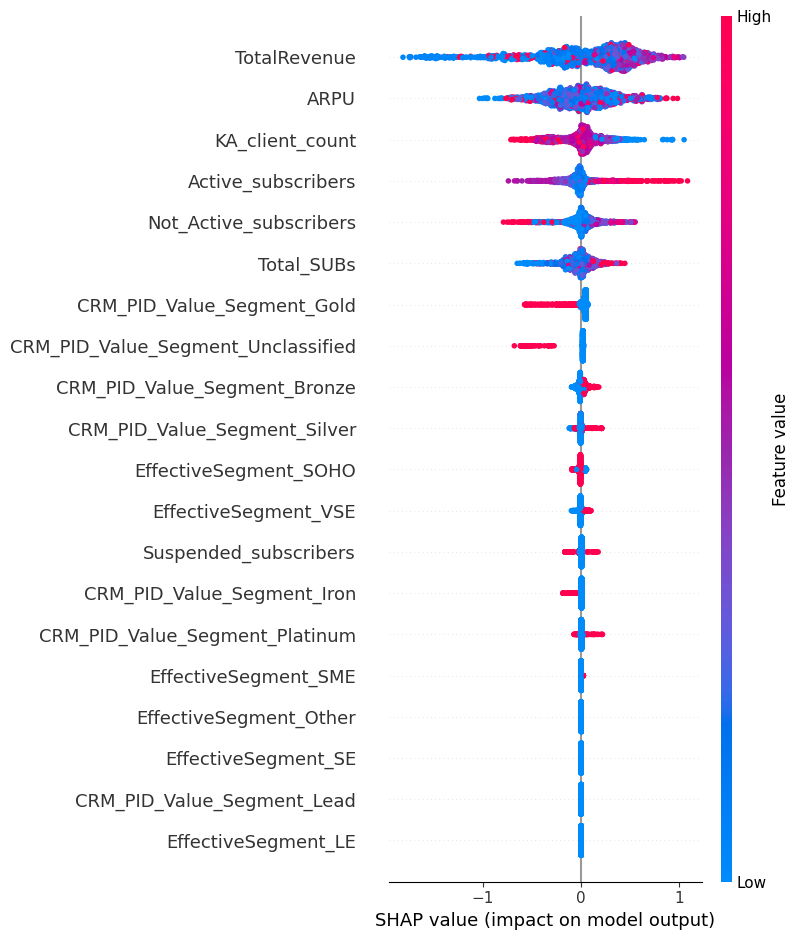

In [ ]:
shap.summary_plot(shap_values, X_test)

顏色代表值的高低，點往右代表推動模型往正類。

根據SHAP的結果，模型由"收入相關特徵"主導。\
包含TotalRevenue 與 ARPU，比客群標籤更能有效區分 churn 風險。

# 實務應用

模型適合用【風險群】+【ARPU】來標記高風險流失的客戶，來進行留存行動。

# 製作補充

調參紀錄\
資料流失率 < 10% ，一開始 RF 的 recall 表現比 LightGBM 好。\
透過限制樹的複雜度與葉節點最小樣本數，刻意讓模型保持不確定性，churn 樣本的預測機率順利從0.2上升至0.4，有效提升 recall，同時維持 ROC 在 0.55 以上。\
最終 LightGBM 的 recall 成功明顯勝過 basline，且 ROC 沒有嚴重下降。

透過調整參數過程，發現：
*  max_depth不要太深，避免樹學到非常明確的不流失規則
* num_leaves不要太多，讓多種可能流失型態在同一葉子上
* min_data_in_leaf決定一個葉子有幾筆資料，數量調高使模型較不易過度擬合

## 各模型測試

In [ ]:
# dt = DecisionTreeClassifier()

# kfold = StratifiedKFold(n_splits=5)
# scores = cross_val_score(dt, X_train, y_train, cv = kfold)

# print(scores)
# print(scores.mean(), scores.std())

[0.8699187  0.86400591 0.86982249 0.86908284 0.85207101]
0.8649801886668678 0.006815639142455827


In [ ]:
# models = [DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     LGBMClassifier(),
#     XGBClassifier()]

# titles = ['DT', 'RF', 'LightGBM', 'XGBOOST']

In [ ]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# results = {}

# for model, name in zip(models, titles):
#     cv_result = cross_validate(
#         model,
#         X_train,
#         y_train,
#         cv=cv,
#         scoring=scoring
#     )
#     results[name] = {
#         k: v.mean() for k, v in cv_result.items()
#     }


[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 21
[LightGBM] [Info] [binary:Bo

In [ ]:
# results

{'DT': {'fit_time': np.float64(0.06598258018493652),
  'score_time': np.float64(0.021478700637817382),
  'test_f1': np.float64(0.10069490114742179),
  'test_recall': np.float64(0.11152037617554858),
  'test_roc_auc': np.float64(0.5178843814359034)},
 'RF': {'fit_time': np.float64(0.9845088481903076),
  'score_time': np.float64(0.0810422420501709),
  'test_f1': np.float64(0.008132094943240454),
  'test_recall': np.float64(0.004571577847439916),
  'test_roc_auc': np.float64(0.568715846661354)},
 'LightGBM': {'fit_time': np.float64(0.14651107788085938),
  'score_time': np.float64(0.0346437931060791),
  'test_f1': np.float64(0.004301075268817204),
  'test_recall': np.float64(0.0022988505747126436),
  'test_roc_auc': np.float64(0.5271905580140284)},
 'XGBOOST': {'fit_time': np.float64(0.15233335494995118),
  'score_time': np.float64(0.028811073303222655),
  'test_f1': np.float64(0.028994845360824743),
  'test_recall': np.float64(0.01598746081504702),
  'test_roc_auc': np.float64(0.537076690

In [ ]:
# %%time

# model_comp = pd.DataFrame()
# cv = StratifiedKFold(n_splits=8)

# for i, model in enumerate(models):
#     model_comp[titles[i]] = \
#         cross_val_score(model, X_train, y_train,
#             scoring = 'recall', cv = cv)

[LightGBM] [Info] Number of positive: 384, number of negative: 5532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 5916, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064909 -> initscore=-2.667662
[LightGBM] [Info] Start training from score -2.667662
[LightGBM] [Info] Number of positive: 384, number of negative: 5532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 5916, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064909 -> initscore=-2.667662
[LightGBM] [Info] Start training from score -2.667662
[LightGBM] [Info] Numb

In [ ]:
def start_plot_hires(figsize=(10, 8), style = 'whitegrid', dpi = 300):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax


<Axes: >

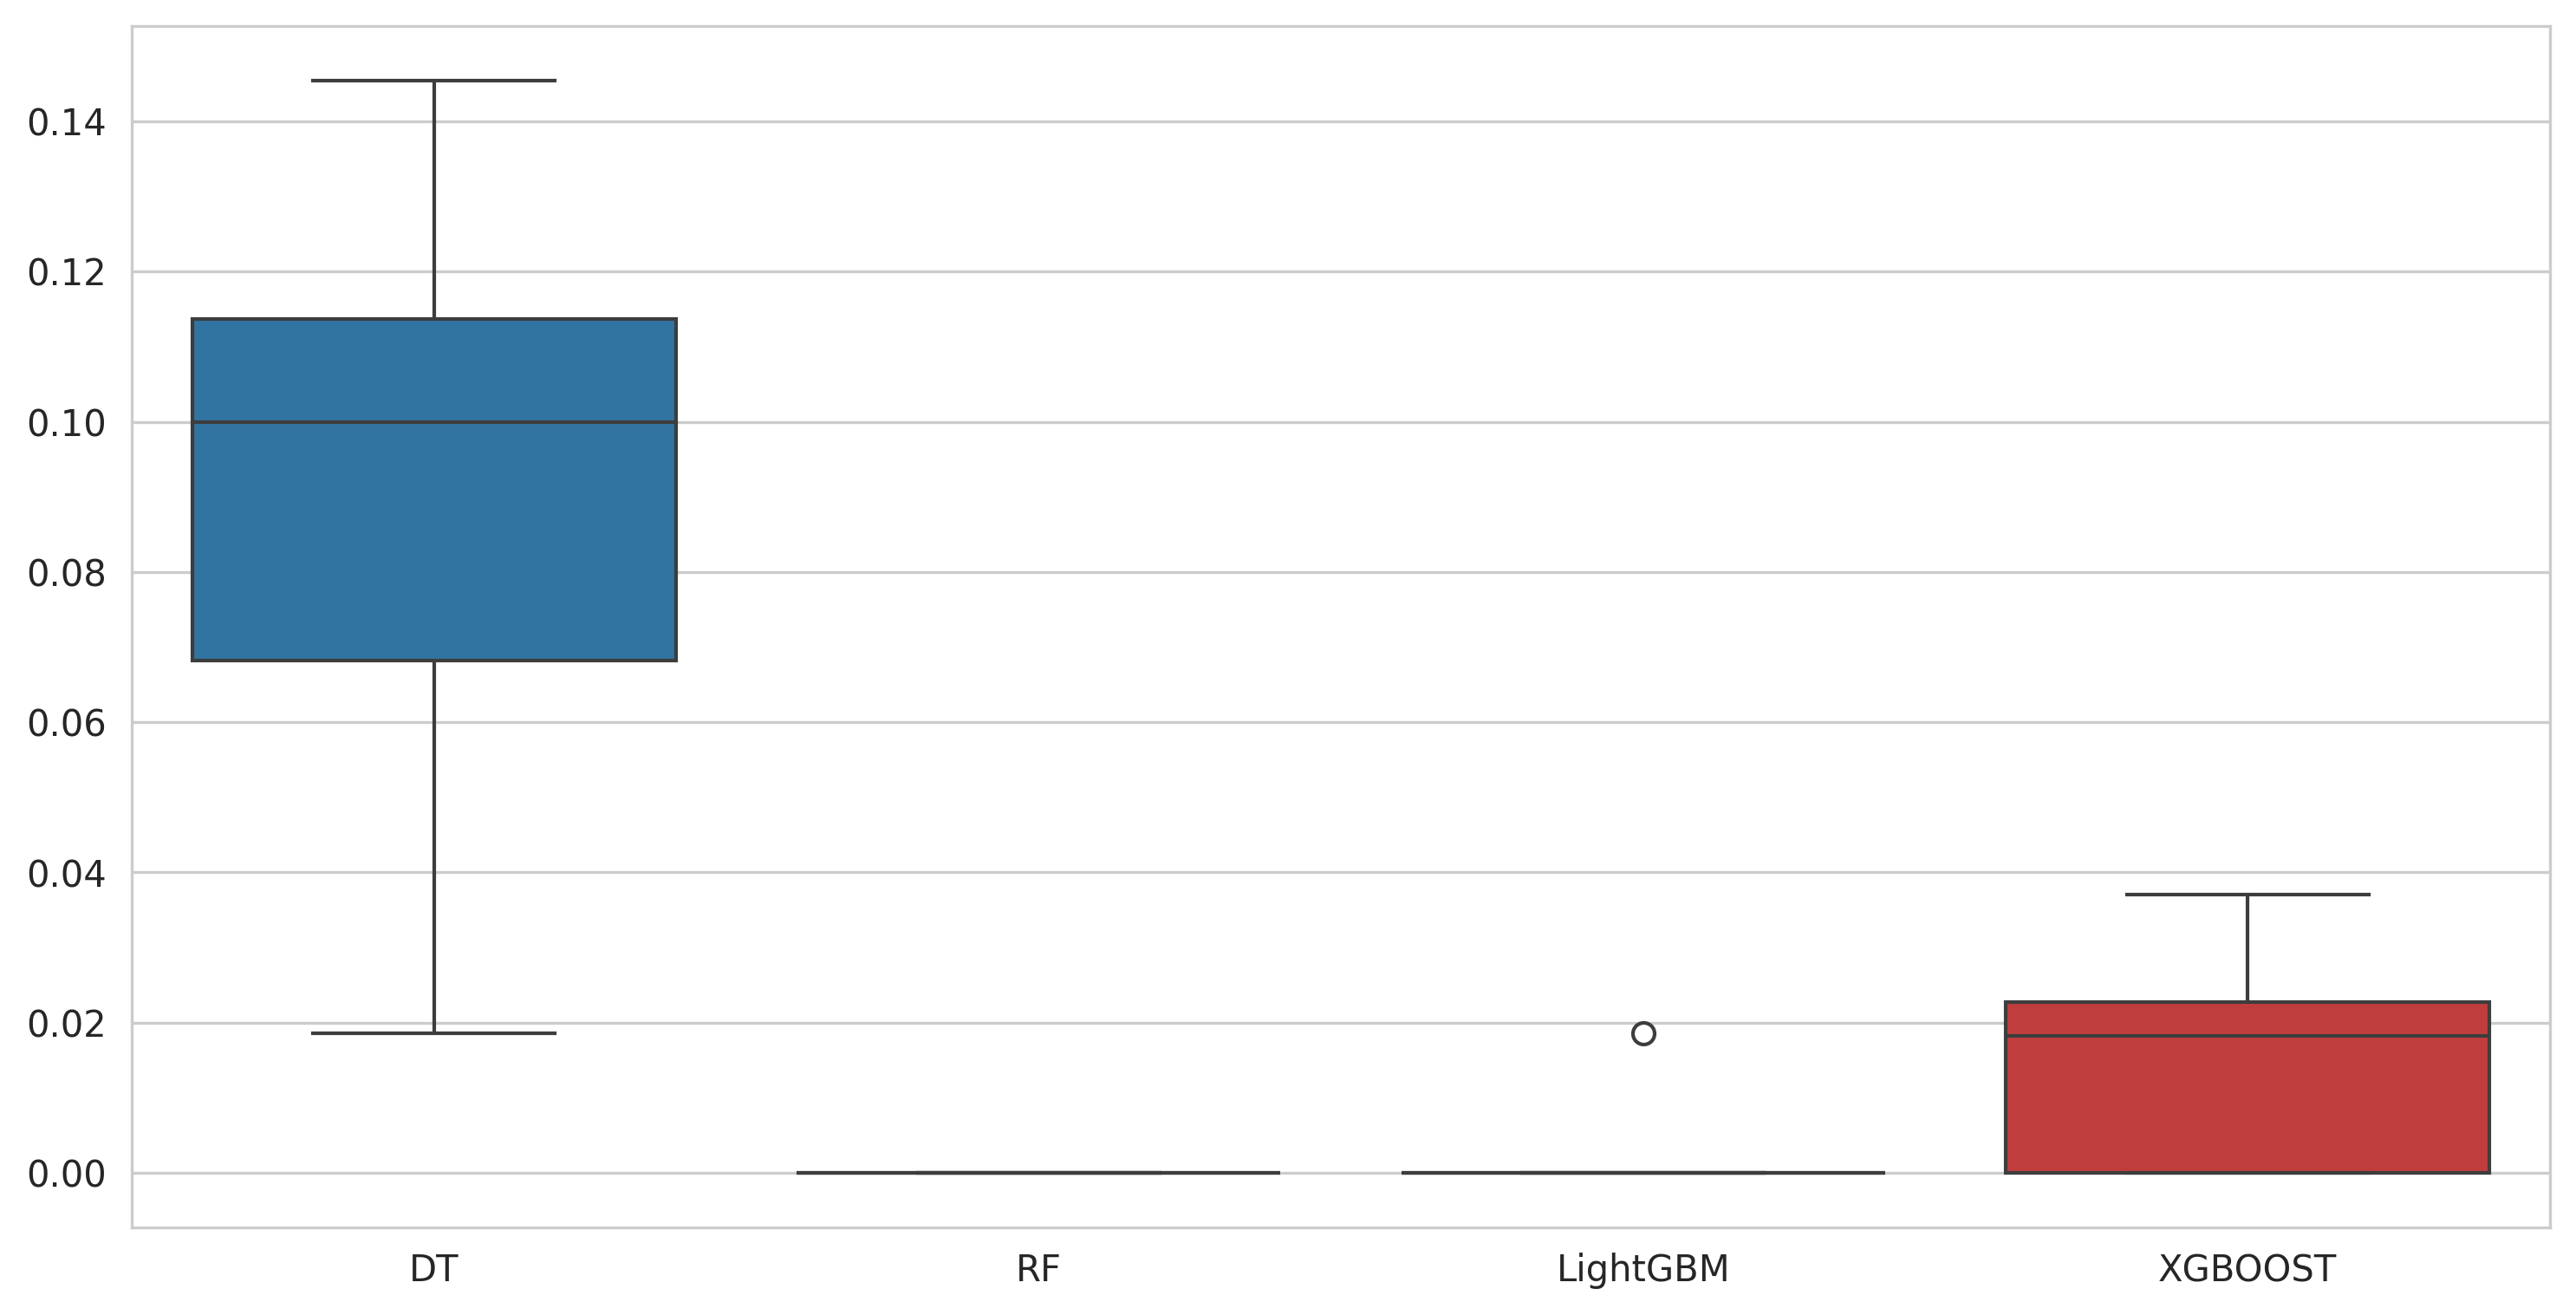

In [ ]:
# ax = start_plot_hires(figsize=(12,6), dpi=300)
# sns.boxplot(data=model_comp, ax=ax)

有模型幾乎不猜churn！

加入參數，觀察變化

In [ ]:
# models = [DecisionTreeClassifier(
#             max_depth=6,
#         min_samples_leaf=50,
#         class_weight='balanced',
#         random_state=42
# ),
#     RandomForestClassifier(
#         n_estimators=300,
#         max_depth=8,
#         class_weight='balanced',
#         random_state=42,
#         n_jobs=-1
#     ),
#     LGBMClassifier(
#         n_estimators=300,
#         is_unbalance=True,
#         random_state=42
#     ),
#     XGBClassifier(
#         n_estimators=300,
#         max_depth=6,
#         scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
#         eval_metric='logloss',
#         random_state=42
#     )]

# titles = ['DT', 'RF', 'LightGBM', 'XGBOOST']

In [ ]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# results = {}

# for model, name in zip(models, titles):
#     cv_result = cross_validate(
#         model,
#         X_train,
#         y_train,
#         cv=cv,
#         scoring=scoring
#     )
#     results[name] = {
#         k: v.mean() for k, v in cv_result.items()
#     }


[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Info] Numb

In [ ]:
# results

{'DT': {'fit_time': np.float64(0.023920631408691405),
  'score_time': np.float64(0.012461471557617187),
  'test_f1': np.float64(0.1261734188830522),
  'test_recall': np.float64(0.5583855799373041),
  'test_roc_auc': np.float64(0.5316941700454303)},
 'RF': {'fit_time': np.float64(1.6682402610778808),
  'score_time': np.float64(0.20106039047241211),
  'test_f1': np.float64(0.11533509813624929),
  'test_recall': np.float64(0.19117032392894462),
  'test_roc_auc': np.float64(0.5577196185226772)},
 'LightGBM': {'fit_time': np.float64(0.32949442863464357),
  'score_time': np.float64(0.07350006103515624),
  'test_f1': np.float64(0.07949798545037903),
  'test_recall': np.float64(0.08202716823406478),
  'test_roc_auc': np.float64(0.5403746384830128)},
 'XGBOOST': {'fit_time': np.float64(0.3811476230621338),
  'score_time': np.float64(0.04326119422912598),
  'test_f1': np.float64(0.08551687247339422),
  'test_recall': np.float64(0.07285788923719957),
  'test_roc_auc': np.float64(0.544563388485692

summary:

---


* 發現模型的ROC都有 > 0.5，表示現階段預測能力比隨機猜還好
* 加入基本參數後，RF開始願意猜流失，recall上升

通常 滿足這三個條件再調參：(很重要！)
1. LightGBM / XGB 明顯贏 RF
2. Recall 有提升
3. Train / CV 差距不大

反之：先回到特徵工程

這邊決定以較常見的兩個模型做為比較對象：RF(baseline) 和 LightGBM。

先調整"不平衡+樹結構"，再設定threshold

## 補充:threshold測試

In [ ]:
# RF_model.fit(X_tr, y_tr)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [ ]:
# y_prob = RF_model.predict_proba(X_val)[:, 1]

In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score, recall_score

# thresholds = np.arange(0.3, 0.5, 0.05) # 逐步往上

# for t in thresholds:
#     y_pred = (y_prob >= t).astype(int)
#     f1 = f1_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     print(f"threshold={t:.2f} | f1={f1:.3f} | recall={recall:.3f}")

threshold=0.30 | f1=0.123 | recall=0.909
threshold=0.35 | f1=0.120 | recall=0.739
threshold=0.40 | f1=0.134 | recall=0.568
threshold=0.45 | f1=0.149 | recall=0.420


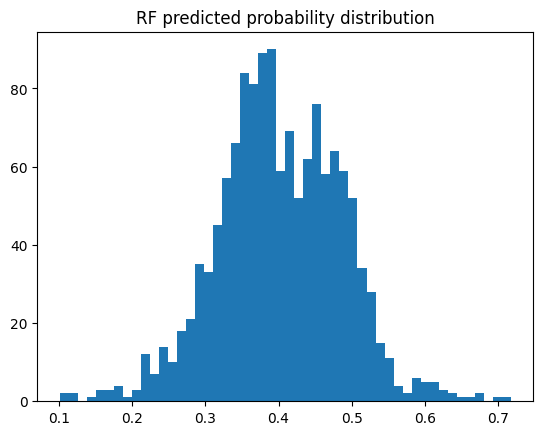

In [ ]:
# plt.hist(y_prob, bins=50)
# plt.title("RF predicted probability distribution")
# plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split

# lgbx_train = X_train
# lgby_train = y_train

# X_tr, X_val, y_tr, y_val = train_test_split(
#     lgbx_train,
#     lgby_train,
#     test_size=0.2,
#     stratify=y_train,
#     random_state=42
# )

In [ ]:
# lgb_model.fit(X_tr, y_tr)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 351, number of negative: 5058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 5409, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064892 -> initscore=-2.667940
[LightGBM] [Info] Start training from score -2.667940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

LGBMClassifier(learning_rate=0.05, max_depth=6, min_data_in_leaf=20,
               n_estimators=500, objective='binary', random_state=42,
               scale_pos_weight=np.float64(14.403189066059225))

In [ ]:
# y_prob = lgb_model.predict_proba(X_val)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [ ]:
# import numpy as np
# from sklearn.metrics import f1_score, recall_score

# thresholds = np.arange(0.3, 0.5, 0.05) # 逐步往上

# for t in thresholds:
#     y_pred = (y_prob >= t).astype(int)
#     f1 = f1_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     print(f"threshold={t:.2f} | f1={f1:.3f} | recall={recall:.3f}")

threshold=0.30 | f1=0.149 | recall=0.386
threshold=0.35 | f1=0.143 | recall=0.318
threshold=0.40 | f1=0.147 | recall=0.273
threshold=0.45 | f1=0.122 | recall=0.193


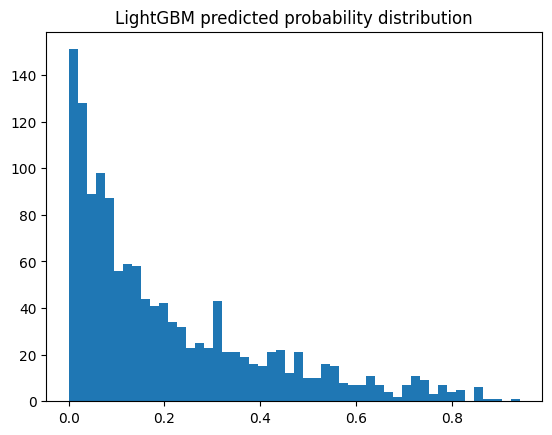

In [ ]:
# plt.hist(y_prob, bins=50)
# plt.title("LightGBM predicted probability distribution")
# plt.show()

發現模型學習問題:可能在流失比率不到一成的資料中，LGBM 的輸出都會呈現偏保守，表示 recall 會無法明顯提升。

<!-- 現在要有一個沒有缺失值的df\
劃分高中低 尚未分類\
顯示 分級 pid ka_name 預測流失 -->


# terminal

In [ ]:
# !pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
# %load_ext colabxterm